Подключаем необходимые библиотеки

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random
import pylab
import numpy.distutils.system_info as sysinfo
import scipy.special
from random import randrange
import math
import sys


Реализация необходимых функция для проведения базового эксперимента. Эксперимент ставится для логистической регресии. Ниже реализованы функции именно для этой базового эксперимента

In [3]:
def f(x): 
    '''
     функция логистической регрессии для всех worker-ов в точке x
    '''
    ans = 0
    for i in range(N):
        ans += math.log(1+math.exp(-b[i]*A[i].dot(x)))/N
    ans += lmbd/2*np.linalg.norm(x)**2
    return ans

def Hessian(x, k, j): 
    '''
    функция для вычисления Гессиана в точке x для i-го workera на j-ой точке его датасэта
    '''
    i = k*m+j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    ans = lmbd*np.eye(d) + alpha*A[i].reshape((d,1)).dot(A[i].reshape(1,d))
    return ans

def coef_computation(x, k, j): 
    '''
    функция для вычисления коэффициента, 
    который стоит перед одноранговой матрицей Гессе для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = b[i]**2*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))**2
    return alpha

def gradient(x, k, j): 
    '''
    вычисление градиента для i-го worker-а на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    ans = lmbd*x+alpha*A[i]
    return ans

def coef_comp(x, k, j):
    '''
    вычисление коэффициента, 
    который стоит перед градиентом для i-го worker-a 
    на j-ой точке его датасэта
    '''
    i = m*k + j
    alpha = -b[i]*math.exp(-b[i]*A[i].dot(x))/(1+math.exp(-b[i]*A[i].dot(x)))
    return alpha



Далее идет считывание данных из датасэта a7a. Для успешного запуска данной ячейки нужно наличие файла `a7a.txt` из репозитория с кодом в той же папке, что текущий ноутбук.

In [11]:
N = 16100            # полное число точек в датасэте
n = 100              # число worker-ов
m = 161              # размер датасэта каждого worker-а
d = 123              # количество признаков (оно же размерность вектора параметра Лог.Регрессии)
lmbd = 0.1           # коэффициент при l_2 регуляризаторе
mu = lmbd            # коэффициент при l_2 регуляризаторе

b = np.zeros((N,))   # вектор меток
A = np.zeros((N, d)) # матрица объект-признак

fle = open('a7a.txt', 'r')
for i, line in enumerate(fle):
    line = line.split()
    for c in line:
        if c == '+1':
            b[i] = 1
        elif c == '-1':
            b[i] = -1
        elif c == '\n':
            continue
        else:
            c = c.split(':')
            A[i][int(c[0]) - 1] = float(c[1])     

Вычисляем константу липшица функциии в задаче Лог.Рег.

In [16]:
L = 1/4*np.linalg.norm(A, 2)**2 
L

25322.463187067755

Вычисление биномиальных коэффициентов, которые понадобятся для расчета количества бит, которые нужно для отправить на мастер-node

In [17]:
stand_nm = [] # массив для запоминания значений функции в методе Ньютона

y = np.ones(d)*0.1 # начальное приближение для оптимальной точки

In [18]:
n_of_steps = 10 # количество шагов оптимизации
for n_step in range(n_of_steps):
    value_stand_nm = f(y) 
    print('St. NM:', value_stand_nm)
    
    # далее идет реализация метода Ньютона
    stand_nm.append(value_stand_nm)
    true_hessian = np.zeros((d,d))
    g = np.zeros(d)
    for k in range(n):
        for j in range(m):
            true_hessian += Hessian(y, k, j)/N
            g += gradient(y, k, j)/N
    y = y - np.linalg.inv(true_hessian).dot(g) 

St. NM: 1.332540211834643
St. NM: 0.5165721472121819
St. NM: 0.47444838829322666
St. NM: 0.47191058499184035
St. NM: 0.47190624706907425
St. NM: 0.4719062470490377
St. NM: 0.4719062470490374
St. NM: 0.4719062470490377
St. NM: 0.47190624704903783
St. NM: 0.4719062470490375


In [19]:
x_star = y # решение при помощи метода Ньютона, используем его в качестве эталона
f(x_star) # выведем значение в оптимуме

0.4719062470490377

In [20]:
max_coef_newton = [] # массив для запоминания значений функции в базовом методе MCNM
max_coef_scaled = [] # массив для запоминания значений функции в модифицированном алгоритме SMCNM
rand_gd = []         # массив для запоминания значений функции в SGD
stand_gd = []        # массив для запоминания значений функции в стандартном GD



scaled_max_coef = [] # массив для запоминания количества отправленных бит на каждом шаге SMCNM
bits_max_coef = []   # массив для запоминания количества отправленных бит на каждом шаге MCNM
bits_rand_gd = []    # массив для запоминания количества отправленных бит на каждом шаге SGD
cur_bits_max_coef = 0 # полное число отправленных бит в MCNM
cur_bits_rand_gd = 0  # полное число отправленных бит в SGD
cur_bits_scaled = 0   # полное число отправленных бит в SMCNM

# начальные точки каждого из алгоритмов
x = np.ones(d)*0.1 # MCNM
z = x              # SMCNM
t = x              # SGD
q=x                # GD


n_of_steps = 20 # количество шагов для каждого из алгоритма
for n_step in range(n_of_steps):
    value = f(q)
    value_max_coef = f(x)
    value_stand_nm = f(y) 
    value_rand_gd = f(z)
    value_stand_gd = f(t)
    print('Scaled Max Coef:', value, 'MaxCoef', value_max_coef, 'Rnd.GD', value_rand_gd, 'St.GD:', value_stand_gd)
    
    # реализация SMCNM
    max_coef_scaled.append(value)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(q, k, j)/coef_computation(x_star, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(q, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*coef_computation(x_star, k, j)*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_scaled += 64*n
    q = q - np.linalg.inv(B).dot(g)
    scaled_max_coef.append(cur_bits_scaled)


    # реализация MCNM
    max_coef_newton.append(value_max_coef)
    B = np.zeros((d,d))
    g = np.zeros(d)
    ans = 0
    for k in range(n):
        max_coef = 0
        for j in range(m):
            current_coef = coef_computation(x, k, j)
            if current_coef > max_coef:
                max_coef = current_coef
            g += gradient(x, k, j)/N
        for j in range(m):
            i = m*k+j
            a = A[i]
            B += max_coef*a.reshape((d,1)).dot(a.reshape((1,d)))/N
    B += mu*np.eye(d)
    cur_bits_max_coef += 64*n
    x = x - np.linalg.inv(B).dot(g)
    bits_max_coef.append(cur_bits_max_coef)

    
    # реализация SGD
    rand_gd.append(value_rand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        j = np.random.choice(m)
        g_global += gradient(z, k, j)/n
    cur_bits_rand_gd += 64*n
    bits_rand_gd.append(cur_bits_rand_gd)
    z = z - 1/L*g_global
    
    # реализация GD
    stand_gd.append(value_stand_gd)
    g_global = np.zeros(d)
    for k in range(n):
        for j in range(m):
            g_global += gradient(t, k, j)/N
    t = t - 1/L*g_global

Scaled Max Coef: 1.332540211834643 MaxCoef 1.332540211834643 Rnd.GD 1.332540211834643 St.GD: 1.332540211834643
Scaled Max Coef: 0.5607770136413298 MaxCoef 0.4869507591544093 Rnd.GD 1.3324585245545746 St.GD: 1.3324566701139249
Scaled Max Coef: 0.48502537437944193 MaxCoef 0.4738602407701045 Rnd.GD 1.3323719608997764 St.GD: 1.3323731354975703
Scaled Max Coef: 0.4721999165295767 MaxCoef 0.47228904790280163 Rnd.GD 1.332288528279668 St.GD: 1.3322896079857471
Scaled Max Coef: 0.47190638756568476 MaxCoef 0.4719823186487655 Rnd.GD 1.3322081084090192 St.GD: 1.3322060875783657
Scaled Max Coef: 0.47190624704907064 MaxCoef 0.47192109262759246 Rnd.GD 1.3321119191058965 St.GD: 1.3321225742753853
Scaled Max Coef: 0.4719062470490382 MaxCoef 0.4719091109691352 Rnd.GD 1.3320313740408756 St.GD: 1.3320390680767573
Scaled Max Coef: 0.4719062470490376 MaxCoef 0.47190679632831845 Rnd.GD 1.3319467191975107 St.GD: 1.3319555689823999
Scaled Max Coef: 0.4719062470490376 MaxCoef 0.4719063521083021 Rnd.GD 1.3318617

Далее делаем сдвиг значений функций относительно оптимума для построения графика

In [21]:
f_optimal = stand_nm[-1]
max_coef_scaled = np.array(max_coef_scaled) - f_optimal
stand_gd = np.array(stand_gd) - f_optimal
max_coef_newton = np.array(max_coef_newton) - f_optimal
stand_nm = np.array(stand_nm) - f_optimal
rand_gd = np.array(rand_gd) - f_optimal

Далее идет ячейка для построения графика, показывающего результаты оптимизации

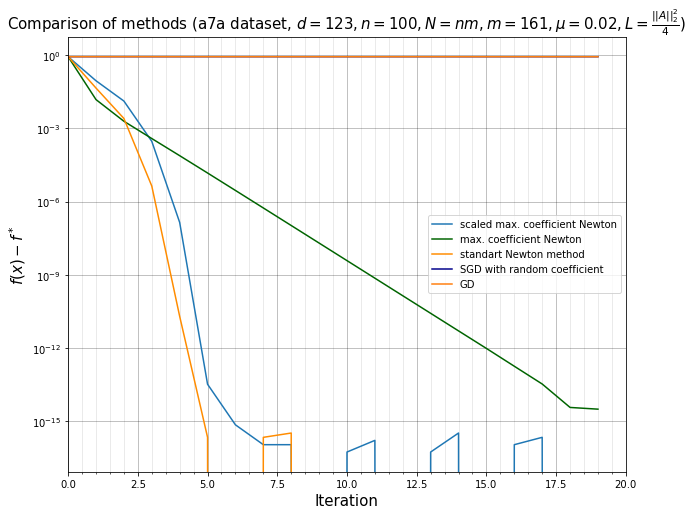

In [23]:
plt.figure(figsize=[10, 8])
pylab.semilogy(range(len(max_coef_scaled)), max_coef_scaled,
               label='scaled max. coefficient Newton')
pylab.semilogy(range(len(max_coef_newton)), max_coef_newton, color='darkgreen',
               label='max. coefficient Newton')
pylab.semilogy(range(len(stand_nm)), stand_nm, color='darkorange',label='standart Newton method')
pylab.semilogy(range(len(rand_gd)), rand_gd, color='darkblue',
               label='SGD with random coefficient')
pylab.semilogy(range(len(stand_gd)), stand_gd, label='GD')

plt.xlim([-0.01, 20])
#plt.ylim([10**(-20), 1])
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('$f(x)-f^*$',fontsize=15)
plt.title(r'Comparison of methods (a7a dataset, $d = 123, n = 100, N = nm, m = 161, \mu=0.02, L = \frac{||A||^2_2}{4})$',fontsize=15)
plt.legend(loc="best")
plt.minorticks_on()
plt.grid(which='major', color='black', alpha =0.3)
plt.grid(which='minor', color='grey', alpha=0.2)
plt.savefig('a7a_dataset_12.png')
plt.show()